In [2]:
import numpy as np
import pandas as pd
import openml
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.compose import make_column_selector, ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import os

In [3]:
def get_model_pipeline(model):
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer()),
        ('scale', MinMaxScaler())
    ])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='constant')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore')),
    ])

    col_trans = ColumnTransformer(
        [('num_pipeline', num_pipeline, make_column_selector(dtype_include=np.number)),
        ('cat_pipeline', cat_pipeline, make_column_selector(dtype_include=['object', 'category']))]
    )

    model_pipeline = Pipeline(steps = [
        ('preprocessing', col_trans),
        ('model', model)
    ])
    return model_pipeline

In [4]:
# load datasets from openml
dataset_ids = [1590, 1471, 44, 1461]
X = []
y = []

for did in dataset_ids:
  dataset = openml.datasets.get_dataset(did)
  df, _, _, _ = dataset.get_data(dataset_format="dataframe")
  target_col = dataset.default_target_attribute
  X.append(df.drop(columns=[target_col]))
  y.append(df[target_col])

#### Random Search

In [5]:
param_dist_rs = {
    'model__C': np.logspace(-4, 4, 10),
    'model__penalty': ['l2', 'elasticnet'],
    'model__l1_ratio': np.linspace(0, 1, 5),
    'model__solver': ['saga'],
    'model__max_iter': [5000]
}

def run_random_search(X, y, dataset_num):
    rs = RandomizedSearchCV(
        estimator=get_model_pipeline(LogisticRegression()),
        cv=3,
        param_distributions=param_dist_rs,
        n_iter=50,
        scoring='roc_auc',
        random_state=42,
        verbose=3
    )
    rs.fit(X, y)

    df = pd.DataFrame(rs.cv_results_)
    df["method"] = "random_search"
    df["dataset"] = dataset_num
    df["iter"] = np.arange(1, len(df) + 1)

    return rs, df

In [6]:
results_path = 'logreg_random_search.pkl'

if not os.path.exists(results_path):
    random_search_fitted = []
    random_search_df = []

    for i in range (4):
        rs, df = run_random_search(X[i], y[i], i)
        random_search_fitted.append(rs)
        random_search_df.append(df)

    # concat all cv_results into a single df
    df_rs_all = pd.concat(random_search_df, ignore_index=True)
    df_rs_all.to_pickle(results_path)
else:
    df_rs_all = pd.read_pickle(results_path)
    
param_cols = [c for c in df_rs_all.columns if c.startswith("param_")]
mean_scores = (
    df_rs_all
    .groupby(param_cols)["mean_test_score"]
    .mean()
    .reset_index()
)

best_row = mean_scores.loc[mean_scores["mean_test_score"].idxmax()]
best_params = best_row[param_cols].to_dict()
best_score = best_row["mean_test_score"]

print("Best hyperparameters:", best_params)
print("Mean performance across datasets:", best_score)

Best hyperparameters: {'param_model__solver': 'saga', 'param_model__penalty': 'elasticnet', 'param_model__max_iter': 5000, 'param_model__l1_ratio': 0.5, 'param_model__C': 2.782559402207126}
Mean performance across datasets: 0.7378867133448622


In [7]:
mask = (df_rs_all[param_cols] == pd.Series(best_params)).all(axis=1)
df_global_best = df_rs_all[mask]
global_best_per_dataset = (
    df_global_best
    .groupby("dataset")["mean_test_score"]
    .mean()  # should be one row per dataset anyway
    .reset_index(name="AUC_global_best")
)

# wynik najlepszej konfiguracji dla danego datasetu: 
individual_best_per_dataset_rs = (
    df_rs_all
    .sort_values("mean_test_score", ascending=False)
    .groupby("dataset")
    .first()
    .reset_index()[["dataset", "mean_test_score"]]
    .rename(columns={"mean_test_score": "AUC_individual_best"})
)

individual_best_per_dataset_rs# porownanie tych wartosci
comparison_rs = pd.merge(global_best_per_dataset, individual_best_per_dataset_rs, on="dataset")
comparison_rs["AUC_diff"] = comparison_rs["AUC_individual_best"] - comparison_rs["AUC_global_best"]
print(comparison_rs)

# tunability modelu: srednia z tych roznic
model_tunability = comparison_rs["AUC_diff"].mean()
print("Model tunability RS:", model_tunability)

   dataset  AUC_global_best  AUC_individual_best  AUC_diff
0        0         0.906104             0.906407  0.000303
1        1         0.521086             0.521964  0.000878
2        2         0.948269             0.954050  0.005781
3        3         0.576088             0.581350  0.005262
Model tunability RS: 0.0030558330046868143


In [8]:
# per-hyperparameter optimization

# wyznaczamy wszystkie przetestowane w rs wartosci dla kazdego hiperparametru
param_values = {p: df_rs_all[p].unique() for p in param_cols}

# funkcja ktora liczy auc dla danego numeru datasetu zestawu hiperparametrow
def evaluate_model(dataset_num, params, cv=3, scoring="roc_auc"):
    model = get_model_pipeline(LogisticRegression(**params))
    scores = cross_val_score(model, X[dataset_num], y[dataset_num], cv=cv, scoring=scoring)
    return np.mean(scores)

# jesli jest plik to sciagam z niego wyniki
results_path = "logreg_per-hyperparameter-tunability.pkl"

if not os.path.exists(results_path):
    # dla kazdego parametru licze roznice miedzy globalnie najlepszym scorem a tylko tym: 
    results = []
    for p in param_cols:
        print(f"Evaluating tunability of {p} ...")
        values = param_values[p]

        for i in range(4):
            aucs = []

            for val in values:
                params = best_params.copy()
                params[p] = val

                params_for_model = {k.replace("param_model__", ""): v for k, v in params.items()} # cutting the 'param_' prefix
                auc = evaluate_model(i, params_for_model)
                aucs.append(auc)

            # najlepszy AUC jesli zmieniamy tylko p
            best_auc_single = max(aucs)

            # AUC dla globalnie optymalnych hiperparametrow
            auc_global = float(
                global_best_per_dataset.loc[
                    global_best_per_dataset["dataset"] == i,
                    "AUC_global_best"
                ]
            )

            diff = best_auc_single - auc_global
            results.append({"hyperparameter": p, "dataset": i, "AUC_diff": diff})
    # usredniamy wyniki tego wyzej zeby dostac per-hyperparameter tunability
    tune_df = pd.DataFrame(results)
    tune_df.to_pickle(results_path)
else:
    tune_df = pd.read_pickle(results_path)

tune_summary = (
    tune_df.groupby("hyperparameter")["AUC_diff"]
    .agg(["mean", "std", "min", "max"])
    .reset_index()
    .sort_values("mean", ascending=False)
)

print(tune_summary)

          hyperparameter          mean           std           min  \
1  param_model__l1_ratio  1.754313e-03  2.589666e-03  1.114345e-04   
0         param_model__C  1.441337e-03  2.892216e-03 -1.409477e-05   
3   param_model__penalty  3.004212e-04  5.961278e-04 -2.969632e-06   
4    param_model__solver  3.623742e-07  2.470015e-06 -1.782163e-06   
2  param_model__max_iter -1.098195e-07  6.015240e-07 -8.382956e-07   

            max  
1  5.564684e-03  
0  5.779649e-03  
3  1.194577e-03  
4  3.893113e-06  
2  5.934155e-07  


#### Bayes Search

In [9]:
from skopt import BayesSearchCV

param_dist_bs = {
  'model__C': (1e-4, 1e4, 'log-uniform'),
  'model__penalty': ['l2', 'elasticnet'],
  'model__solver': ['saga'],
  'model__l1_ratio': (0.0, 1.0),   # tylko dla elasticnet!
  'model__max_iter': [5000]
}

def run_bayes_search(X, y, dataset_num):
    model_pipeline = get_model_pipeline(LogisticRegression(solver="saga", max_iter=5000))
    bayes = BayesSearchCV(
        estimator=model_pipeline,
        search_spaces=param_dist_bs,
        n_iter=50,
        cv=3,
        scoring='roc_auc',
        random_state=42,
        verbose=3
    )
    bayes.fit(X, y)
    df = pd.DataFrame(bayes.cv_results_)
    df["method"] = "bayes"
    df["dataset"] = dataset_num
    return bayes, df

In [10]:
results_path = "logreg_bayes_search.pkl"

if not os.path.exists(results_path):
  random_bayes_fitted = []
  random_bayes_df = []

  for i in range(4):    # analogicznie jak w random search
    bayes, df = run_bayes_search(X[i], y[i], i)
    random_bayes_fitted.append(bayes)
    random_bayes_df.append(df)

    df_bayes_all = pd.concat(random_bayes_df, ignore_index=True)
    df_bayes_all.to_pickle(results_path)

else:
  df_bayes_all = pd.read_pickle(results_path)


In [11]:
individual_best_per_dataset_bs = (
    df_bayes_all
    .sort_values("mean_test_score", ascending=False)
    .groupby("dataset")
    .first()
    .reset_index()[["dataset", "mean_test_score"]]
    .rename(columns={"mean_test_score": "AUC_individual_best"})
)

In [12]:
comparison_bs = pd.merge(global_best_per_dataset, individual_best_per_dataset_bs, on="dataset")
comparison_bs["AUC_diff"] = comparison_bs["AUC_individual_best"] - comparison_bs["AUC_global_best"]
print(comparison_bs)

model_tunability = comparison_bs["AUC_diff"].mean()
print("Model tunability BS:", model_tunability)

   dataset  AUC_global_best  AUC_individual_best  AUC_diff
0        0         0.906104             0.906487  0.000383
1        1         0.521086             0.522348  0.001262
2        2         0.948269             0.954125  0.005856
3        3         0.576088             0.581004  0.004916
Model tunability BS: 0.003104247187685011


In [13]:
df_rs = comparison_rs.rename(columns={
    "AUC_individual_best": "AUC_best_rs",
    "AUC_diff": "AUC_diff_rs"
})

df_bs = comparison_bs.rename(columns={
    "AUC_individual_best": "AUC_best_bs",
    "AUC_diff": "AUC_diff_bs"
})

In [14]:
df_merged = pd.merge(df_rs, df_bs, on=["dataset", "AUC_global_best"])
df_merged

,dataset,AUC_global_best,AUC_best_rs,AUC_diff_rs,AUC_best_bs,AUC_diff_bs
0,0,0.906104,0.906407,0.000303,0.906487,0.000383
1,1,0.521086,0.521964,0.000878,0.522348,0.001262
2,2,0.948269,0.954050,0.005781,0.954125,0.005856
3,3,0.576088,0.581350,0.005262,0.581004,0.004916


In [15]:
# tunability modelu: srednia z tych roznic (osobno dla bs i rs)
rs_tunability = df_merged["AUC_diff_rs"].mean()
print("RS model tunability:", rs_tunability)

bs_tunability = df_merged["AUC_diff_bs"].mean()
print("BS model tunability: ", bs_tunability)

RS model tunability: 0.0030558330046868143
BS model tunability:  0.003104247187685011


#### Analiza

Ile iteracji każdej metody potrzebujemy żeby uzyskać stabilne wyniki optymalizacji?

In [16]:
# dodajemy nr iteracji do df_bayes_all
df_bayes_all = df_bayes_all.copy()
df_bayes_all["iter"] = (
    df_bayes_all.groupby(["dataset", "method"]).cumcount() + 1
)
# df_bayes_all.columns
# df_rs_all.columns
df_hist = pd.concat([df_rs_all, df_bayes_all], ignore_index=True)

def iterations_to_stable_auc(history, patience=20, tol=1e-3):
    auc = history.sort_values("iter")["mean_test_score"].cummax().values
    # czy przez następne "patience" running iteracji running-best wynik wzrośnie o mniej niż "tol"
    for i in range(len(auc) - patience):
        max_future = auc[i + 1:i + 1 + patience].max()
        if (max_future - auc[i]) < tol:
            return i + 1
    return len(auc)

results = [] # wyniki dla każdego zbioru danych i każdej metody
for (dataset, method), history in df_hist.groupby(["dataset", "method"]):
    iters = iterations_to_stable_auc(history) # po ilu teracjach wynik przestał znaczącą się poprawiać
    results.append({"dataset": dataset, "method": method, "iters_to_stable": iters})

results_df = pd.DataFrame(results)
print(results_df)
print("\n\nPodsumowanie stabilności - średnia i mediana:")
print(results_df.groupby("method")["iters_to_stable"].agg(["mean", "median", "min", "max"]))

   dataset         method  iters_to_stable
0        0          bayes                2
1        0  random_search                1
2        1          bayes               16
3        1  random_search                2
4        2          bayes                4
5        2  random_search                3
6        3          bayes               10
7        3  random_search               10


Podsumowanie stabilności - średnia i mediana:
               mean  median  min  max
method                               
bayes           8.0     7.0    2   16
random_search   4.0     2.5    1   10


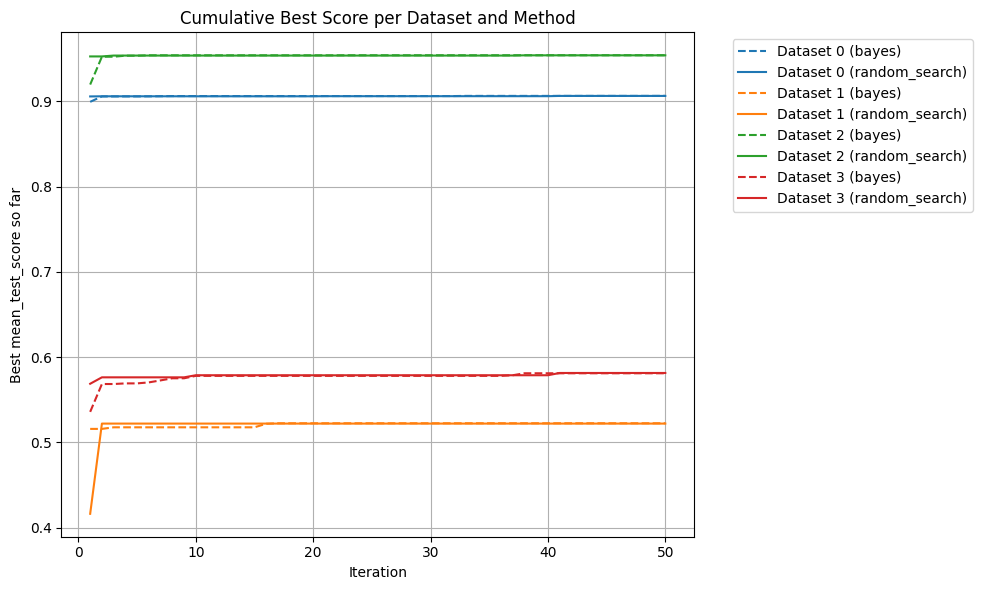

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: sort and compute cumulative max
df_sorted = df_hist.sort_values(['dataset', 'method', 'iter'])
df_sorted['cummax_score'] = (
    df_sorted.groupby(['dataset', 'method'])['mean_test_score'].cummax()
)

# Step 2: define styles
line_styles = {'random_search': '-', 'bayes': '--'}

# Get consistent colors per dataset
datasets = sorted(df_sorted['dataset'].unique())
cmap = plt.get_cmap('tab10')  # or any palette you like
colors = {ds: cmap(i) for i, ds in enumerate(datasets)}

# Step 3: plot
plt.figure(figsize=(10, 6))

for (dataset, method), group in df_sorted.groupby(['dataset', 'method']):
    plt.plot(
        group['iter'],
        group['cummax_score'],
        color=colors[dataset],
        linestyle=line_styles[method],
        label=f"Dataset {dataset} ({method})"
    )

plt.xlabel('Iteration')
plt.ylabel('Best mean_test_score so far')
plt.title('Cumulative Best Score per Dataset and Method')
plt.grid(True)

# Avoid duplicate legend entries for same dataset
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.savefig(os.path.join("plots", "cumulative_best_score_per_dataset_logreg.jpg"), dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


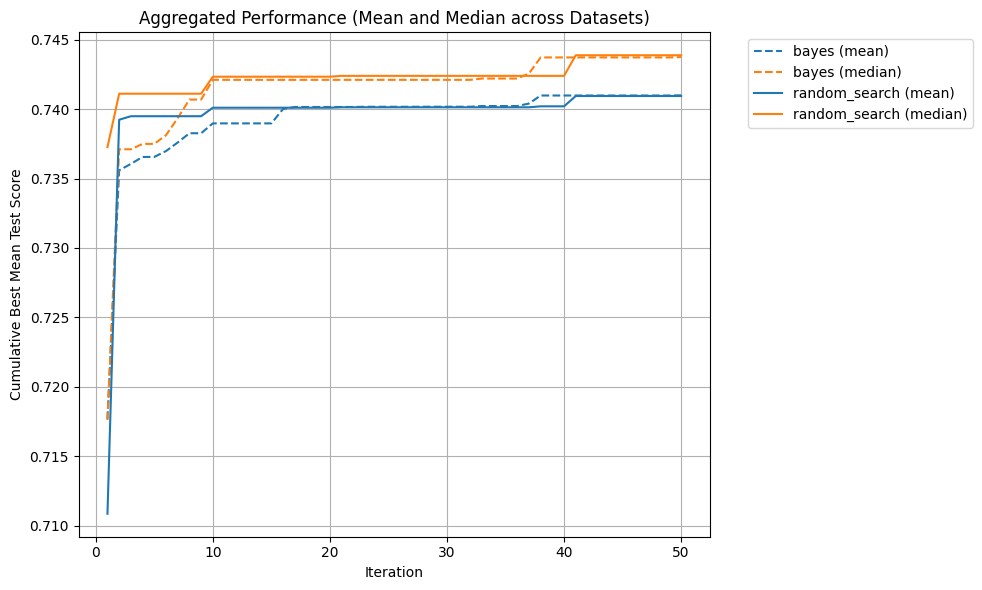

In [ ]:
# srednie i medianowe krzywe running-best - porownanie metod

# calculate aggregated cummax_score between datasets - mean and median
agg_df = (
    df_sorted
    .groupby(['method', 'iter'])['cummax_score']
    .agg(['mean', 'median'])
    .reset_index()
)

# set up chart style
line_styles = {'random_search': '-', 'bayes': '--'}
colors = {'mean': '#1f77b4', 'median': '#ff7f0e'}

# plot
plt.figure(figsize=(10, 6))

for method in agg_df['method'].unique():
    method_data = agg_df[agg_df['method'] == method]

    for stat in ['mean', 'median']:
        plt.plot(
            method_data['iter'],
            method_data[stat],
            linestyle=line_styles[method],
            color=colors[stat],
            label=f"{method} ({stat})"
        )

plt.xlabel('Iteration')
plt.ylabel('Cumulative Best Mean Test Score')
plt.title('Aggregated Performance (Mean and Median across Datasets)')
plt.grid(True)

# remove duplicates in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
# plt.savefig(os.path.join("plots", "aggregated_performance_logreg.jpg"), dpi=300, bbox_inches='tight')
plt.show()

Określenie zakresów hiperparametrów dla poszczególnych modeli - motywacja wynikająca z literatury.

In [18]:
TOP_FRAC = 0.01 # % najlepszych wynikow dla kazdego datasetu

# biore ten top % wynikow dla kazdego datasetu
cutoffs = (
    df_hist.groupby('dataset')['mean_test_score']
    .quantile(1 - TOP_FRAC)
    .rename('cutoff')
)
df_with_cutoff = df_hist.join(cutoffs, on='dataset')
top20 = df_with_cutoff[df_with_cutoff['mean_test_score'] >= df_with_cutoff['cutoff']]

# wybieram taki range kazdego hiperparametru ktory zawiera wszystkie wartosci w tym top %
param_cols = [c for c in df_hist.columns if c.startswith('param_')]

param_ranges = {}
for col in param_cols:
    series = top20[col].dropna()

    # numeric / integer range
    if np.issubdtype(series.dtype, np.integer):
        if not series.empty:
            param_ranges[col] = [int(series.min()), int(series.max())]
        else:
            param_ranges[col] = None

    # non-numeric categorical/string/bool → list of unique values
    else:
        param_ranges[col] = sorted(series.unique().tolist())

print(param_ranges)

{'param_model__solver': ['saga'], 'param_model__penalty': ['elasticnet', 'l2'], 'param_model__max_iter': [5000, 5000], 'param_model__l1_ratio': [0.0, 1.0], 'param_model__C': [0.3593813663804626, 0.5302345567573493, 2.4490771262083566, 71.43074486823853]}


Bias sampling - porównanie rozkładów

In [19]:
print("Tunowalność algorytmów")
print(f"Random Search tunability: {comparison_rs['AUC_diff'].mean():.4f}")
print(f"Bayes Search tunability: {comparison_bs['AUC_diff'].mean():.4f}")
print(f"Różnica: {comparison_bs['AUC_diff'].mean() - comparison_rs['AUC_diff'].mean():.4f}")
print()

print("Per dataset:")
print(df_merged[['dataset', 'AUC_diff_rs', 'AUC_diff_bs']])

Tunowalność algorytmów
Random Search tunability: 0.0031
Bayes Search tunability: 0.0031
Różnica: 0.0000

Per dataset:
   dataset  AUC_diff_rs  AUC_diff_bs
0        0     0.000303     0.000383
1        1     0.000878     0.001262
2        2     0.005781     0.005856
3        3     0.005262     0.004916


In [20]:
# różnice dla każdego datasetu i metody
tuning_diffs = []

for (dataset, method), group in df_hist.groupby(['dataset', 'method']):
    best_score = group['mean_test_score'].max()
    for _, row in group.iterrows():
        diff = best_score - row['mean_test_score']
        tuning_diffs.append({
            'dataset': dataset,
            'method': method,
            'iteration': row['iter'],
            'score_diff_from_best': diff
        })
tuning_diffs_df = pd.DataFrame(tuning_diffs)
tuning_diffs_df.head()

,dataset,method,iteration,score_diff_from_best
0,0,bayes,1,0.006998
1,0,bayes,2,0.000668
2,0,bayes,3,0.004504
3,0,bayes,4,0.000632
4,0,bayes,5,0.000633


dataset baselines: {0: 0.9061039704376439, 1: 0.5210858572226283, 2: 0.9482691175724366, 3: 0.5760879081467402}

Dataset 0
Baseline AUC: 0.9061
Median tunability RS=-0.0041, BS=-0.0003
Wilcoxon test p-value: 0.0186
Significant difference (p < 0.05)

Dataset 1
Baseline AUC: 0.5211
Median tunability RS=-0.0202, BS=-0.0069
Wilcoxon test p-value: 0.0046
Significant difference (p < 0.05)

Dataset 2
Baseline AUC: 0.9483
Median tunability RS=-0.0221, BS=0.0039
Wilcoxon test p-value: 0.0029
Significant difference (p < 0.05)

Dataset 3
Baseline AUC: 0.5761
Median tunability RS=-0.0079, BS=-0.0069
Wilcoxon test p-value: 0.0035
Significant difference (p < 0.05)


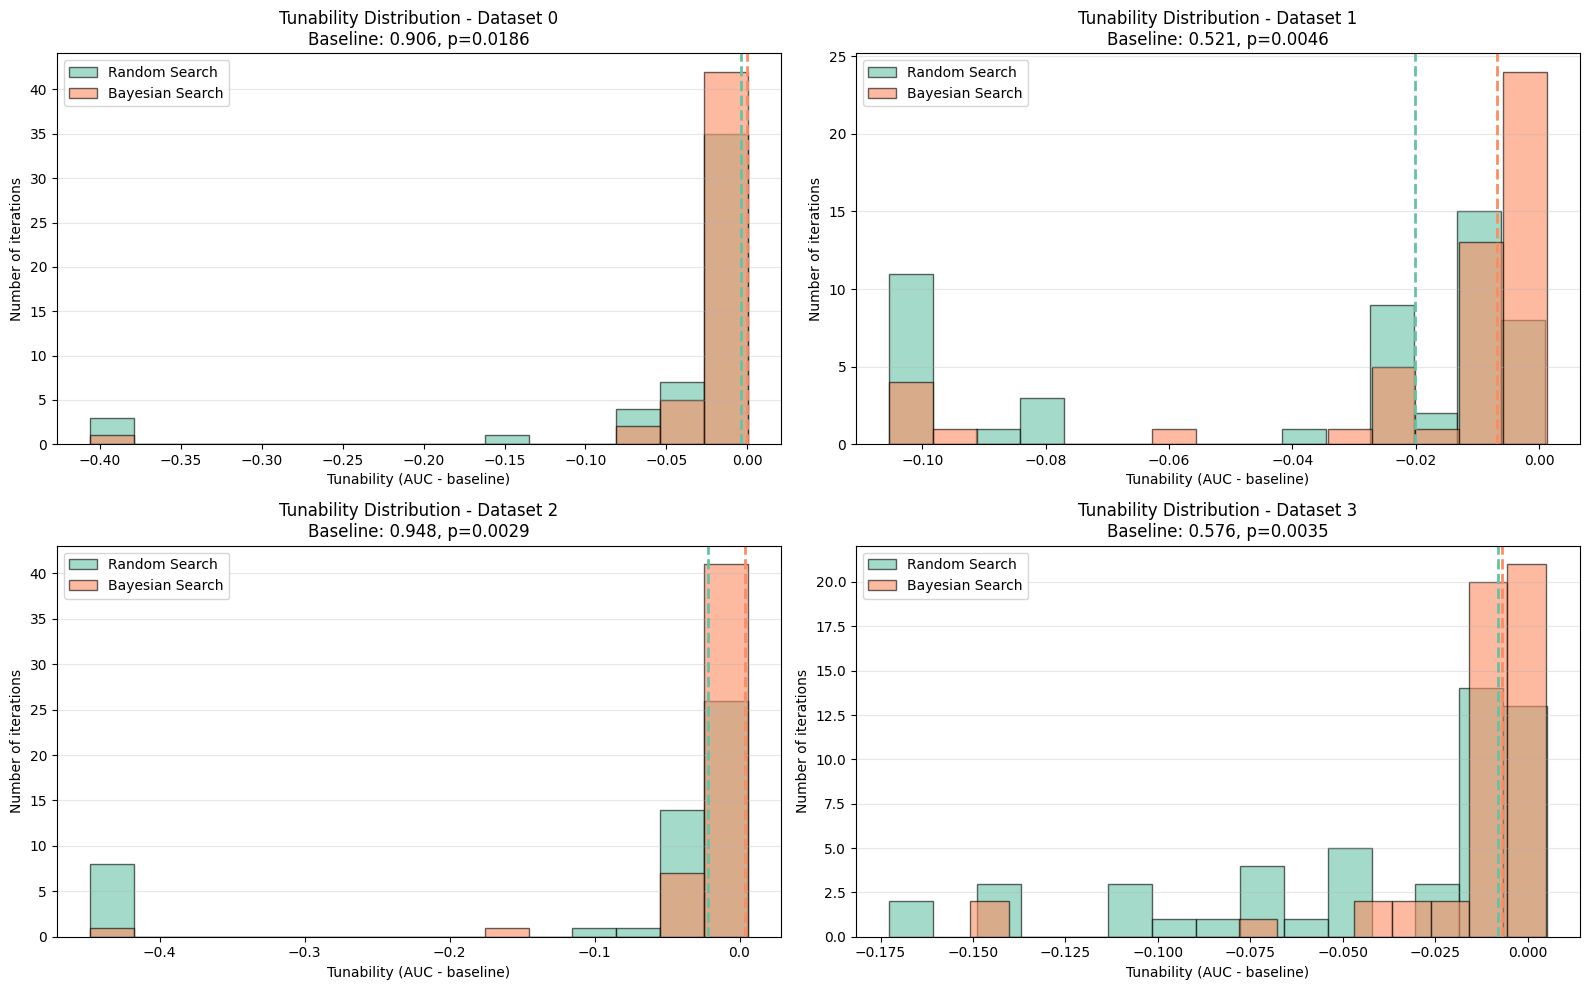

     dataset  baseline_auc  median_rs  median_bs  wilcoxon_p
0  Dataset 0        0.9061    -0.0041    -0.0003      0.0186
1  Dataset 1        0.5211    -0.0202    -0.0069      0.0046
2  Dataset 2        0.9483    -0.0221     0.0039      0.0029
3  Dataset 3        0.5761    -0.0079    -0.0069      0.0035


In [ ]:
# tunability per dataset with Wilcoxon test
from scipy.stats import wilcoxon

dataset_baselines = df_merged.set_index('dataset')['AUC_global_best'].to_dict()
print("dataset baselines:", dataset_baselines)

def calculate_tunability_correct(row):
    dataset_id = row['dataset']
    baseline = dataset_baselines[dataset_id]
    return row['mean_test_score'] - baseline

df_hist["tunability"] = df_hist.apply(calculate_tunability_correct, axis=1)

method_colors = {
    "random_search": "#66c2a5",
    "bayes": "#fc8d62" 
}

results = []
dataset_names = ["Dataset " + str(i) for i in range(4)]

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()  # Make it easier to iterate through

for i, ds_name in enumerate(dataset_names):
    ds_data = df_hist[df_hist["dataset"] == i]
    
    rs_tunability = ds_data[ds_data["method"] == "random_search"]["tunability"].dropna()
    bs_tunability = ds_data[ds_data["method"] == "bayes"]["tunability"].dropna()
    
    n = min(len(rs_tunability), len(bs_tunability))
    rs_tunability = rs_tunability.iloc[:n]
    bs_tunability = bs_tunability.iloc[:n]

    stat, p = wilcoxon(rs_tunability, bs_tunability)
    results.append({
        "dataset": ds_name,
        "baseline_auc": dataset_baselines[i],
        "median_rs": np.median(rs_tunability),
        "median_bs": np.median(bs_tunability),
        "wilcoxon_p": p
    })
    
    print(f"\n{ds_name}")
    print(f"Baseline AUC: {dataset_baselines[i]:.4f}")
    print(f"Median tunability RS={np.median(rs_tunability):.4f}, BS={np.median(bs_tunability):.4f}")
    print(f"Wilcoxon test p-value: {p:.4f}")
    if not np.isnan(p):
        if p < 0.05:
            print("Significant difference (p < 0.05)")
        else:
            print("No significant difference (p ≥ 0.05)")
    
    # Plot on the corresponding subplot
    ax = axes[i]
    ax.hist(rs_tunability, bins=15, alpha=0.6, label="Random Search",
            color=method_colors["random_search"], edgecolor="black")
    ax.hist(bs_tunability, bins=15, alpha=0.6, label="Bayesian Search",
            color=method_colors["bayes"], edgecolor="black")
    ax.axvline(np.median(rs_tunability), color=method_colors["random_search"], 
               linestyle="--", linewidth=2)
    ax.axvline(np.median(bs_tunability), color=method_colors["bayes"], 
               linestyle="--", linewidth=2)
    
    ax.set_title(f"Tunability Distribution - {ds_name}\nBaseline: {dataset_baselines[i]:.3f}, p={p:.4f}")
    ax.set_xlabel("Tunability (AUC - baseline)")
    ax.set_ylabel("Number of iterations")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()

# Create plots directory if it doesn't exist
plots_dir = "plots"
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Save the plot as JPG
# plt.savefig(os.path.join(plots_dir, "tunability_distribution_grid_logreg.jpg"), dpi=300, bbox_inches='tight')

plt.show()

results_df = pd.DataFrame(results)
print(results_df.round(4))